IPSuite uses [DVC](https://dvc.org) to manage its files and workflows. In this part we will fit different GAP models to our data and compare them.

In [1]:
import os  # environment variables for GAP Model
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
import ipsuite as ips

/data/fzills/miniconda3/envs/ipsuite/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-09 18:17:17.151337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 18:17:17.225417: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 18:17:17.798477: W tensorflow/compiler/xla/stream_executor/platform/defau

2023-03-09 18:17:18,959 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [3]:
with ips.Project() as project:
    data = ips.AddData(file="KCl1650K.extxyz", lines_to_read=100)
    test_data = ips.configuration_selection.UniformEnergeticSelection(
        data=data, n_configurations=10, name="test_data"
    )
    # we have now given the Nodes a "name" attribute to uniquly identify them
    train_data = ips.configuration_selection.RandomSelection(
        data=data,
        n_configurations=5,
        exclude_configurations=test_data.exclude_configurations,
        name="train_data",
    )
    model = ips.models.GAP(train_data=train_data)
    prediction = ips.analysis.PredictWithModel(model=model, atoms=test_data)
    analyse = ips.analysis.AnalysePrediction(prediction=prediction)
project.run()


Running DVC command: 'stage add --name AddData --force ...'
Running DVC command: 'stage add --name test_data --force ...'
Running DVC command: 'stage add --name train_data --force ...'
Running DVC command: 'stage add --name MLModel --force ...'
Running DVC command: 'stage add --name PredictWithModel --force ...'
Running DVC command: 'stage add --name AnalysePrediction --force ...'
Running DVC command: 'repro'


We can now invesitage our Model.

In [4]:
analyse.load()
print(analyse.energy)
print(analyse.forces)

{'rmse': 0.1700091633310196, 'mae': 0.10109757829122827, 'max': 0.4325127607517061, 'lp4': 0.04481685239251717, 'pearsonr': 0.9998583703845423}
{'rmse': 0.07724451171605197, 'mae': 0.06230391603745587, 'max': 0.35552722249022284, 'lp4': 0.0005833453573625671, 'pearsonr': 0.9808652967579897}


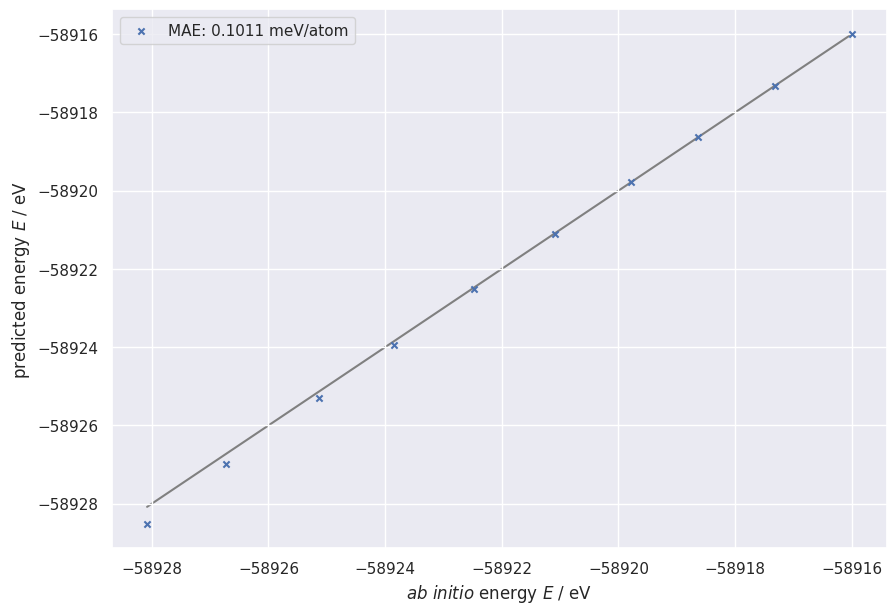

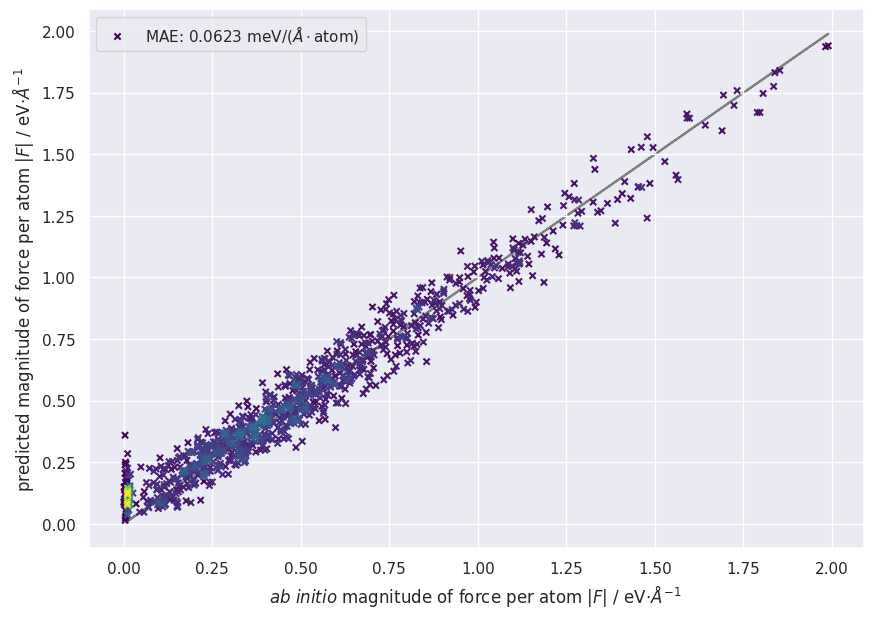

In [5]:
analyse.get_plots()

We can use `dvc dag --mermaid` to display the graph that was created for us:

[![](https://mermaid.ink/img/pako:eNpdkdFKwzAUhl-lnOtt2Lm20AtBnFdbQfRC0IiE5tQG0mSkp7o69u6edV1Xe3fy_X8OH8kBcqcQUiiM-8lL6SnYPgsryDIO3wXcK7WWJAV8XOjyRK00bY1PHpXOSTs7ym853zyYMI5uNgvc0779XajvfNRYcSPbZjyZEY2Y9gtfNZXTOOaYvNT2U_33SU4B1jTl4Xx-112cgmQw7UE4iPUgGpx6sBwspo2kB6spiGEGFfpKasXPexA2CNizxAoFpDwqLGRjSICwR642O9bHR6XJeUjJNzgD2ZB7aW1-OZ87ay2_vKwgLaSpme6kfXPuesZuR3b-1u53j3-xQ6q3?type=png)](https://mermaid.live/edit#pako:eNpdkdFKwzAUhl-lnOtt2Lm20AtBnFdbQfRC0IiE5tQG0mSkp7o69u6edV1Xe3fy_X8OH8kBcqcQUiiM-8lL6SnYPgsryDIO3wXcK7WWJAV8XOjyRK00bY1PHpXOSTs7ym853zyYMI5uNgvc0779XajvfNRYcSPbZjyZEY2Y9gtfNZXTOOaYvNT2U_33SU4B1jTl4Xx-112cgmQw7UE4iPUgGpx6sBwspo2kB6spiGEGFfpKasXPexA2CNizxAoFpDwqLGRjSICwR642O9bHR6XJeUjJNzgD2ZB7aW1-OZ87ay2_vKwgLaSpme6kfXPuesZuR3b-1u53j3-xQ6q3)

If we want to train our model on a different amount of training data, we can modify the `train_data` Node.
This will only rerun nodes that are dependent on the `train_data` Node. In our case, this means that the `test_data` Node won't be affect and we can ensure, that all models are evaluated on the same test data.

To compare `experiments` we need to create them first.

In [6]:
with project.create_experiment(name="baseline") as exp1 :
    # this will store the current experiment with the name "baseline"
    pass

with project.create_experiment() as exp2:
    train_data.n_configurations = 10

with project.create_experiment() as exp3:
    train_data.n_configurations = 3

project.run_exp()

Running DVC command: 'exp run --queue --name baseline'
Running DVC command: 'exp run --queue'
Running DVC command: 'exp run --queue'
Running DVC command: 'exp run --run-all'


Now let's have a look at the results. We can load the Experiments using `exp.load` followed by `exp.nodes['node-name']` or  via `Node.from_rev(rev=<name>)`.

In [7]:
for exp in [exp3, exp1, exp2]:
    exp.load()
    print(f"'{exp.name}': {exp['train_data'].n_configurations = }")

'third-yate': exp['train_data'].n_configurations = 3
'baseline': exp['train_data'].n_configurations = 5
'adult-taal': exp['train_data'].n_configurations = 10


In [8]:
print(analyse.from_rev(rev=exp3.name).energy)
print(analyse.from_rev(rev=exp1.name).energy)
print(analyse.from_rev(rev=exp2.name).energy)

{'rmse': 0.1741629326282149, 'mae': 0.11186990495407372, 'max': 0.427335767490149, 'lp4': 0.04431734106984371, 'pearsonr': 0.9998479713079558}
{'rmse': 0.1700091633310196, 'mae': 0.10109757829122827, 'max': 0.4325127607517061, 'lp4': 0.04481685239251717, 'pearsonr': 0.9998583703845423}
{'rmse': 0.09710961285065708, 'mae': 0.051970034852274694, 'max': 0.27341142859950196, 'lp4': 0.027620796969794893, 'pearsonr': 0.9999182846096089}


In [9]:
# We want to remove the experiments here, so we can rerun the Notebook.
!dvc exp remove -A

Removed experiments: adult-taal,baseline,third-yate                   
